In [59]:
library(tidyverse)
library(ggpubr)
library(treemapify)
library(vegan)
library(umap)
library(ggrepel)
library(rnaturalearth)
library(rnaturalearthdata)
library(sf)
library(ggpmisc)
library(mgcv)

source("../src/dd_functions.r")
source("../src/spreads.r")

options(jupyter.plot_scale=1)

This notebook contains the code for running the analyses, creating tables and figures for the following sections:
* Figure 2
* Figure 3
* Figure S8
* Figure S9
* Table S2
* Table S3

In here, we are only using R code.

In [2]:
# Set the directory of where dataframes are saved
data.dir = '../data'

# Set the directory of where figures are saved to
fig.dir = '../fig/db_comparisons_reviewer3'

In [3]:
# Load in metadata for samples and ARGs
metadata <- read_csv(
    file.path(data.dir, 'csv_files', 'metadata_fixed.csv'), 
    show_col_types=F
) %>%
    mutate(city = case_when(
            city == 'Santiago' & country == 'Spain' ~ 'Santiago_ESP',
            TRUE ~ city
        )
    )
panres.meta <- read_csv(
    file.path(data.dir, 'csv_files', 'panres_metadata_fixed.csv'), 
    show_col_types=F
) %>%
    mutate(
        group_db = case_when(
            is.na(group) ~ 'Other ARGs',
            T ~ group
            )
        )

New names:
• `` -> `...1`


In [4]:
# Load in and format the data output of flankophile
flankophile.dat <- read_delim(
    file = file.path(data.dir, 'data', 'flankophile_output', 'initial_run', '1_hits_all.tsv'), 
    show_col_types= F
) 

flankophile.dat1 <- flankophile.dat %>%
    mutate(
        tool = case_when(
            str_detect(pattern='spades', string = METADATA) ~ 'spades',
            TRUE ~ 'seed_extender'
        ),
        sampleName = basename(`#FILE`) %>% 
            str_replace_all(
                c(
                    ".scaf.min1000.fa" = "",
                    ".scaffolds.min1000.fasta" = "",
                    "_L\\d{3}$" =  "",
                    "P1$" = "",
                    "'_S\\d{3}$" = ""
                )
            )
        #.str.replace(r'_S\d+$', '', regex=True).str.replace(r'P1$', '', regex=True)
    ) %>% 
    filter(
        tool == 'spades'
    )

flankophile.dat2 <- flankophile.dat1 %>%
    mutate(
        genepid = as.double(str_extract(sampleName, "\\d{7}")),
        gene = str_extract(GENE, 'pan_\\d+')
    ) %>%
    left_join(
        metadata %>% distinct(genepid, city, country, Region,country_alpha3, year),
        by=c("genepid"),
        na_matches = "never"
    ) %>% 
     left_join(
        metadata %>% distinct(alternative_name, city, country, Region, country_alpha3, year), 
        by=c("sampleName" = "alternative_name"),
        na_matches = "never",
        relationship="many-to-many"
    ) %>%
    mutate(
        city = case_when(
            !is.na(city.x) ~ city.x,
            TRUE ~ city.y
            ),
        country = case_when(
            !is.na(country.x) ~ country.x,
            TRUE ~ country.y
        ),
        Region = case_when(
            !is.na(Region.x) ~ Region.x,
            TRUE ~ Region.y
        ),
        country_alpha3 = case_when(
            !is.na(country_alpha3.x) ~ country_alpha3.x,
            TRUE ~ country_alpha3.y
        ),
        year = case_when(
            !is.na(year.x) ~ year.x,
            TRUE ~ year.y
        )
    ) %>%
    select(-c(city.x, city.y, country.x, country.y, Region.x, Region.y, country_alpha3.x, country_alpha3.y, year.x, year.y)) %>%
    left_join(
        panres.meta %>% distinct(gene, group_db, class),
        by="gene",
        na_matches = "never"
    ) %>%
    rename(group=group_db) %>%
    filter(!is.na(group)) %>%
    unique %>%
    mutate(
        class2 = str_split(str_replace_all(class, c("'" = "", "\\[" = "", "\\]" = "", " "="")), ","),
        variant = str_c(gene, VARIANT, sep = '_'),
        city = case_when(
            city == 'Santiago' & country == 'Spain' ~ 'Santiago_ESP',
            TRUE ~ city
        )
    )

flankophile.dat3 <- flankophile.dat2 %>% unnest_longer(class2)
resClasses <- sort(unique(flankophile.dat3$class2))


In [5]:
# Coloring palettes
dbpalette <- c("Acquired" = "#FC766AFF", "FG" = "#5B84B1FF",  "Other ARGs" = "#4c956c")

region_palette = list(
    'East Asia & Pacific' = '#FEFF32',
    'Europe & Central Asia' = '#4BAD49',
    'Latin America & Caribbean' = '#A75529',
    'Middle East & North Africa' = '#974EA2',
    'North America' = '#FF8000',
    'South Asia' = '#3A7EB5',
    'Sub-Saharan Africa' = '#E4191C'
)

scale_palette = list(
    "Within Country" = "#F8766D", 
    "Within Region" = "#00BFC4", 
    "Between Regions" = "#C77CFF"
)


# Spread of alleles and variants

In [6]:
flankophile.dat2 %>%
    summarise(
        n_gene = n_distinct(gene),
        n_contigs = n_distinct(SEQUENCE),
        n_variants = n_distinct(variant)
    )

n_gene,n_contigs,n_variants
<int>,<int>,<int>
2747,194380,71654


In [7]:
flankophile.dat2 %>%
    group_by(group) %>%
    summarise(
        n_gene = n_distinct(gene),
        n_contigs = n_distinct(SEQUENCE),
        n_variants = n_distinct(variant),
        n_assembly = n_distinct(ASSEMBLY_NAME)
    )

group,n_gene,n_contigs,n_variants,n_assembly
<chr>,<int>,<int>,<int>,<int>
Functional,1181,56091,21119,1425
Other ARGs,1114,116227,44437,1428
ResFinder,452,28482,6098,1426


In [8]:
flankophile.dat2 %>%
    group_by(group, gene) %>%
    summarise(n_variants = n_distinct(variant)) %>%
    group_by(group) %>%
    summarise(
        median_variants = median(n_variants),
        min_variants = min(n_variants),
        max_variants = max(n_variants)
        )

`summarise()` has grouped output by 'group'. You can override using the `.groups` argument.


group,median_variants,min_variants,max_variants
<chr>,<dbl>,<int>,<int>
Functional,4,1,325
Other ARGs,6,1,293
ResFinder,3,1,269


In [9]:
flankophile.dat2 %>%
    group_by(group, variant) %>%
    summarise(
        n_contigs = n_distinct(SEQUENCE),
    ) %>%
    filter(n_contigs > 1) %>%
    group_by(group) %>%
    summarise(
        not_singleton = n_distinct(variant)
    )

`summarise()` has grouped output by 'group'. You can override using the `.groups` argument.


group,not_singleton
<chr>,<int>
Functional,3283
Other ARGs,7028
ResFinder,1060


In [10]:
spreadData <- generate_spread(
    dat1 = flankophile.dat2,
    dat2 = flankophile.dat3 %>% select(-class) %>% rename(class = class2),
    geo_levels=c("Region", "country", "city"),
    resClasses = resClasses,
    groups = c("ResFinder", "Functional", "Other ARGs")
) %>% mutate(
    group = case_when(
        group == 'ResFinder' ~ 'Acquired',
        group == 'Functional' ~ 'FG',
        T ~ 'Other ARGs'
        )
    )


[1] "ResFinder gene Region"


Warning message:
“Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(geo_level)

  # Now:
  data %>% select(all_of(geo_level))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.”
Warning message:
“Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(arg_level)

  # Now:
  data %>% select(all_of(arg_level))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.”


[1] "ResFinder gene country"
[1] "ResFinder gene city"
[1] "ResFinder variant Region"
[1] "ResFinder variant country"
[1] "ResFinder variant city"
[1] "Functional gene Region"
[1] "Functional gene country"
[1] "Functional gene city"
[1] "Functional variant Region"
[1] "Functional variant country"
[1] "Functional variant city"
[1] "Other ARGs gene Region"
[1] "Other ARGs gene country"
[1] "Other ARGs gene city"
[1] "Other ARGs variant Region"
[1] "Other ARGs variant country"
[1] "Other ARGs variant city"


### Figure S8

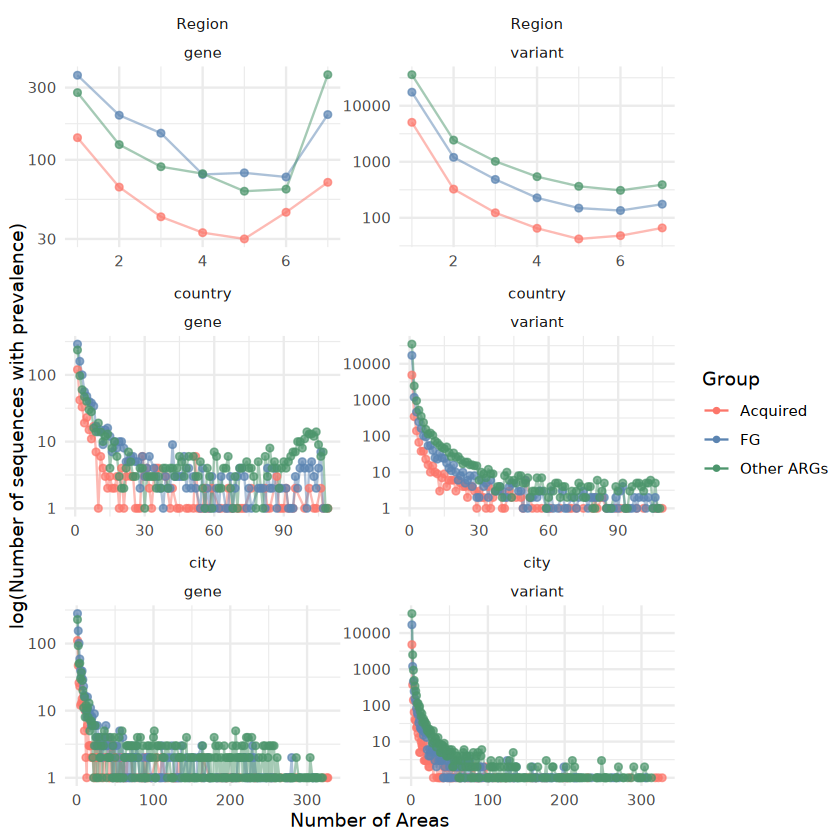

In [11]:
spreadData %>% filter(res_class == 'All') %>%
    ggplot(aes(x=numberAreas, y = n, color=factor(group, levels=c('Acquired', 'FG', 'Other ARGs')))) +
    geom_line(alpha = .5) +
    geom_point(alpha = .7) + 
    facet_wrap(geo_level ~ arg_level, scales='free', ncol = 2) +
    scale_y_log10() +
    scale_color_manual(values = dbpalette) +
    theme_minimal() +
        labs(
            y="log(Number of sequences with prevalence)",
             x = "Number of Areas"
        ) +
    guides(
        col = guide_legend(title='Group', override.aes = list(shape=16, alpha=1, lw=0))
    )

ggsave(
    filename=file.path(fig.dir, "all_spreads_areas_log10.png"),
    height=11.7, width=8.3
)
ggsave(
    filename=file.path(fig.dir, "all_spreads_areas_log10.pdf"),
    height=11.7, width=8.3
)
ggsave(
    filename=file.path(fig.dir, "all_spreads_areas_log10.tiff"),
    height=11.7, width=8.3
)

# Distance-Decays

## Distance-Decay of Quantified Resistomes (Abundances)

In [12]:
resfinder_clr <- read_csv(file.path(fig.dir, 'clr_city_acquired.csv'), show_col_types = F)
functional_clr <- read_csv(file.path(fig.dir, 'clr_city_fg.csv'), show_col_types = F)
other_clr <- read_csv(file.path(fig.dir, 'clr_city_other_args.csv'), show_col_types = F)
genera_clr <- read_csv(file.path(data.dir, 'csv_files', 'clr_city_genera.csv'), show_col_types = F)

In [13]:
# Distances between cities
city_dists <- create_physical_dd(metadata, geoCol='city')

# Resistome CLR similarities with Euclidean distances
resfinder_clr_dists <- make_clr_similarity(resfinder_clr, id_col='city', method='euclidean') %>% rename(sim.euclidean.rf = sim.euclidean)
functional_clr_dists <- make_clr_similarity(functional_clr, id_col='city', method='euclidean') %>% rename(sim.euclidean.fg = sim.euclidean)
other_clr_dists <- make_clr_similarity(other_clr, id_col='city', method='euclidean') %>% rename(sim.euclidean.other = sim.euclidean)
genera_clr_dists <- make_clr_similarity(genera_clr, id_col='city', method='euclidean')

abn.dists.regions <- city_dists %>%
    left_join(resfinder_clr_dists, by=c("area1" = "city", "area2" = "city_2")) %>%
    left_join(functional_clr_dists, by=c("area1" = "city", "area2" = "city_2")) %>%
    left_join(other_clr_dists, by=c("area1" = "city", "area2" = "city_2")) %>%
    left_join(genera_clr_dists, by=c("area1" = "city", "area2" = "city_2")) %>%
    mutate(
        across(starts_with("sim."), ~ 1 - .x, .names = "dis{.col}")
    ) %>%
    left_join(
        metadata %>% distinct(city, country, Region), by=c("area1" = "city")
    )%>%
    left_join(
        metadata %>% distinct(city, country, Region), by=c("area2" = "city"), suffix=c(".1", ".2")
    ) %>%
    filter(across(everything(), ~!is.na(.) & !is.nan(.))) %>% 
    mutate(
        dist_km = as.numeric(value) / 1000,
        log_distance = log(dist_km),
        log_rf_similarity = log(sim.euclidean.rf),
        log_fg_similarity = log(sim.euclidean.fg),
        log_other_similarity = log(sim.euclidean.other),
        log_bac_similarity = log(sim.euclidean),
        log_rf_dissimilarity = log(1-sim.euclidean.rf),
        log_fg_dissimilarity = log(1-sim.euclidean.fg),
        log_other_dissimilarity = log(1-sim.euclidean.other),
        log_bac_dissimilarity = log(1-sim.euclidean),
        spatial_scale = factor(
                    case_when(
                    country.1 == country.2 ~ 'Within Country',
                    country.1 != country.2 & Region.1 == Region.2 ~ 'Within Region',
                    TRUE ~ 'Between Regions'
                ),
                levels=c('Within Country', 'Within Region', 'Between Regions')
            )
    )

Warning message:
“`group_by_()` was deprecated in dplyr 0.7.0.
ℹ Please use `group_by()` instead.
ℹ See vignette('programming') for more help”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message:
“Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(drop_columns)

  # Now:
  data %>% select(all_of(drop_columns))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.”
Warning message:
“Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `

In [14]:
metrics <- c('log_bac_dissimilarity', 'log_rf_dissimilarity', 'log_fg_dissimilarity', 'log_other_dissimilarity')
metric_pairs <- tidyr::crossing(x = metrics, y = metrics) %>%
    filter(x!=y) %>%
    rowwise() %>%
    filter(x < y) %>%
    ungroup()

metric_pairs %>%
    mutate(
        result = map2(x, y, ~run_mantel(data=abn.dists.regions, x = .x, y = .y)$table)
    ) %>%
    unnest(result)

x,y,r,p.value,signif
<chr>,<chr>,<dbl>,<dbl>,<chr>
log_bac_dissimilarity,log_fg_dissimilarity,0.76,0.001,**
log_bac_dissimilarity,log_other_dissimilarity,0.73,0.001,**
log_bac_dissimilarity,log_rf_dissimilarity,0.70,0.001,**
log_fg_dissimilarity,log_other_dissimilarity,0.85,0.001,**
log_fg_dissimilarity,log_rf_dissimilarity,0.78,0.001,**
log_other_dissimilarity,log_rf_dissimilarity,0.90,0.001,**


In [15]:
run_mantel(
    data = abn.dists.regions,
    x = 'log_bac_dissimilarity',
    y = 'log_rf_dissimilarity'
    
)$table

r,p.value,signif
<dbl>,<dbl>,<chr>
0.7,0.001,**


In [16]:
run_mantel(
    data = abn.dists.regions,
    x = 'log_bac_dissimilarity',
    y = 'log_fg_dissimilarity'
    
)$table

r,p.value,signif
<dbl>,<dbl>,<chr>
0.76,0.001,**


In [17]:
run_mantel(
    data = abn.dists.regions,
    x = 'log_rf_dissimilarity',
    y = 'log_fg_dissimilarity'
    
)$table

r,p.value,signif
<dbl>,<dbl>,<chr>
0.78,0.001,**


### Figure 2

In [18]:
min_maxs <- abn.dists.regions %>% 
    mutate(across(where(is.numeric), ~ replace(., is.nan(.) | is.infinite(.), NA))) %>%
    summarise(across(where(is.numeric), list(min=min, max=max), na.rm=T))

ymin <- min(min_maxs %>% select(log_rf_similarity_min, log_fg_similarity_min, log_bac_similarity_min))
ymax <- max(min_maxs %>% select(log_rf_similarity_max, log_fg_similarity_max, log_bac_similarity_max))

xmin <- min_maxs$log_distance_min
xmax <- min_maxs$log_distance_max

Warning message:
“There was 1 warning in `summarise()`.
ℹ In argument: `across(where(is.numeric), list(min = min, max = max), na.rm = T)`.
Caused by warning:
! The `...` argument of `across()` is deprecated as of dplyr 1.1.0.
Supply arguments directly to `.fns` through an anonymous function instead.

  # Previously
  across(a:b, mean, na.rm = TRUE)

  # Now
  across(a:b, \(x) mean(x, na.rm = TRUE))”


In [19]:
abn.dists.rf.lms <- build_lms(
    abn.dists.regions, 
    x = 'log_distance', 
    y = 'log_rf_similarity', 
    z='spatial_scale',
    palette = scale_palette,
    calc_mantel = T,
    xlabel = 'Ln(Geodesic distance) (km)',
    ylabel = 'Ln(Resistome Similarity) (Euclidean)',
    title='Distance-Decay of abundance of acquired genes',
    ymin = ymin, 
    ymax = ymax
)

Warning message:
“Using `across()` in `filter()` was deprecated in dplyr 1.0.8.
ℹ Please use `if_any()` or `if_all()` instead.”
Warning message in x.mat[upper.tri(x.mat)] <- data %>% arrange(!!sym(g1), !!sym(g2)) %>% :
“number of items to replace is not a multiple of replacement length”
Warning message in y.mat[upper.tri(y.mat)] <- data %>% arrange(!!sym(g1), !!sym(g2)) %>% :
“number of items to replace is not a multiple of replacement length”
Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.”
Warning message in x.mat[upper.tri(x.mat)] <- data %>% arrange(!!sym(g1), !!sym(g2)) %>% :
“number of items to replace is not a multiple of replacement length”
Warning message in y.mat[upper.tri(y.mat)] <- data %>% arrange(!!sym(g1), !!sym(g2)) %>% :
“number of items to replace is not a multiple of replacement length”
Warning message in x.mat[upper.tri(x.mat)] <- da

In [20]:
abn.dists.fg.lms <- build_lms(
    abn.dists.regions, 
    x = 'log_distance', 
    y = 'log_fg_similarity', 
    z='spatial_scale',
    palette = scale_palette,
    calc_mantel = T,
    xlabel = 'Ln(Geodesic distance) (km)',
    ylabel = 'Ln(Resistome Similarity) (Euclidean)',
    title='Distance-Decay of abundance of FG genes',
    ymin = ymin, 
    ymax = ymax
)

Warning message:
“Using `across()` in `filter()` was deprecated in dplyr 1.0.8.
ℹ Please use `if_any()` or `if_all()` instead.”
Warning message in x.mat[upper.tri(x.mat)] <- data %>% arrange(!!sym(g1), !!sym(g2)) %>% :
“number of items to replace is not a multiple of replacement length”
Warning message in y.mat[upper.tri(y.mat)] <- data %>% arrange(!!sym(g1), !!sym(g2)) %>% :
“number of items to replace is not a multiple of replacement length”
Warning message in x.mat[upper.tri(x.mat)] <- data %>% arrange(!!sym(g1), !!sym(g2)) %>% :
“number of items to replace is not a multiple of replacement length”
Warning message in y.mat[upper.tri(y.mat)] <- data %>% arrange(!!sym(g1), !!sym(g2)) %>% :
“number of items to replace is not a multiple of replacement length”
Warning message in x.mat[upper.tri(x.mat)] <- data %>% arrange(!!sym(g1), !!sym(g2)) %>% :
“number of items to replace is not a multiple of replacement length”
Warning message in y.mat[upper.tri(y.mat)] <- data %>% arrange(!!sym(g1)

In [21]:
abn.dists.other.lms <- build_lms(
    abn.dists.regions, 
    x = 'log_distance', 
    y = 'log_other_similarity', 
    z='spatial_scale',
    palette = scale_palette,
    calc_mantel = T,
    xlabel = 'Ln(Geodesic distance) (km)',
    ylabel = 'Ln(Resistome Similarity) (Euclidean)',
    title='Distance-Decay of abundance of Other ARGs',
    ymin = ymin, 
    ymax = ymax
)

Warning message:
“Using `across()` in `filter()` was deprecated in dplyr 1.0.8.
ℹ Please use `if_any()` or `if_all()` instead.”
Warning message in x.mat[upper.tri(x.mat)] <- data %>% arrange(!!sym(g1), !!sym(g2)) %>% :
“number of items to replace is not a multiple of replacement length”
Warning message in y.mat[upper.tri(y.mat)] <- data %>% arrange(!!sym(g1), !!sym(g2)) %>% :
“number of items to replace is not a multiple of replacement length”
Warning message in x.mat[upper.tri(x.mat)] <- data %>% arrange(!!sym(g1), !!sym(g2)) %>% :
“number of items to replace is not a multiple of replacement length”
Warning message in y.mat[upper.tri(y.mat)] <- data %>% arrange(!!sym(g1), !!sym(g2)) %>% :
“number of items to replace is not a multiple of replacement length”
Warning message in x.mat[upper.tri(x.mat)] <- data %>% arrange(!!sym(g1), !!sym(g2)) %>% :
“number of items to replace is not a multiple of replacement length”
Warning message in y.mat[upper.tri(y.mat)] <- data %>% arrange(!!sym(g1)

In [22]:
abn.dists.bac.lms <- build_lms(
    abn.dists.regions, 
    x = 'log_distance', 
    y = 'log_bac_similarity', 
    z='spatial_scale',
    palette = scale_palette,
    calc_mantel = T,
    xlabel = 'Ln(Geodesic distance) (km)',
    ylabel = 'Ln(Bacteriome Similarity) (Euclidean)',
    title='Distance-Decay of abundance of bacterial genera',
    ymin = ymin, 
    ymax = ymax
)

Warning message:
“Using `across()` in `filter()` was deprecated in dplyr 1.0.8.
ℹ Please use `if_any()` or `if_all()` instead.”
Warning message in x.mat[upper.tri(x.mat)] <- data %>% arrange(!!sym(g1), !!sym(g2)) %>% :
“number of items to replace is not a multiple of replacement length”
Warning message in y.mat[upper.tri(y.mat)] <- data %>% arrange(!!sym(g1), !!sym(g2)) %>% :
“number of items to replace is not a multiple of replacement length”
Warning message in x.mat[upper.tri(x.mat)] <- data %>% arrange(!!sym(g1), !!sym(g2)) %>% :
“number of items to replace is not a multiple of replacement length”
Warning message in y.mat[upper.tri(y.mat)] <- data %>% arrange(!!sym(g1), !!sym(g2)) %>% :
“number of items to replace is not a multiple of replacement length”
Warning message in x.mat[upper.tri(x.mat)] <- data %>% arrange(!!sym(g1), !!sym(g2)) %>% :
“number of items to replace is not a multiple of replacement length”
Warning message in y.mat[upper.tri(y.mat)] <- data %>% arrange(!!sym(g1)

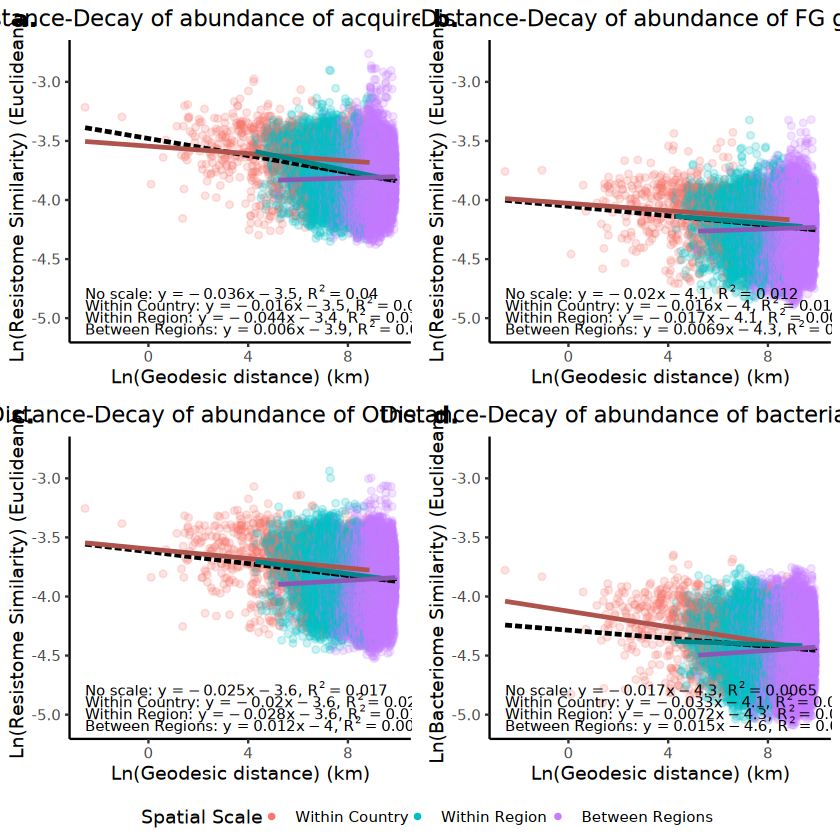

In [23]:
ggarrange(
    add_plot_equations(p=abn.dists.rf.lms$p, eqns=abn.dists.rf.lms$equations, ymin=ymin, xmin=xmin) ,
    add_plot_equations(p=abn.dists.fg.lms$p, eqns=abn.dists.fg.lms$equations, ymin=ymin, xmin=xmin),
    add_plot_equations(p=abn.dists.other.lms$p, eqns=abn.dists.other.lms$equations, ymin=ymin, xmin=xmin),
    add_plot_equations(p=abn.dists.bac.lms$p, eqns=abn.dists.bac.lms$equations, ymin=ymin, xmin=xmin),
    nrow=2,ncol=2,
    common.legend = T,
    legend = "bottom",
    labels = c("a.", "b.", "c.", "d.")
)

ggsave(file.path(fig.dir, "dd_plots_abundances_euclidean_sim.png"), height = 15, width = 15)
ggsave(file.path(fig.dir, "dd_plots_abundances_euclidean_sim.pdf"), height = 15, width = 15)
ggsave(file.path(fig.dir, "dd_plots_abundances_euclidean_sim.tiff"), height = 15, width = 15)

### Slopes

In [24]:
abn.lm.summaries <- rbind(
    abn.dists.rf.lms$fit.summaries %>% left_join(abn.dists.rf.lms$mantel.results, by = ("model"), suffix = c(".fit", ".mantel")) %>% mutate(Collection = 'Acquired'),
    abn.dists.fg.lms$fit.summaries %>% left_join(abn.dists.fg.lms$mantel.results, by = ("model"), suffix = c(".fit", ".mantel")) %>% mutate(Collection = 'FG'),
    abn.dists.other.lms$fit.summaries %>% left_join(abn.dists.other.lms$mantel.results, by = ("model"), suffix = c(".fit", ".mantel")) %>% mutate(Collection = 'Other ARGs'),
    abn.dists.bac.lms$fit.summaries%>% left_join(abn.dists.bac.lms$mantel.results, by = ("model"), suffix = c(".fit", ".mantel")) %>% mutate(Collection = 'Genera')
)
abn.lm.summaries

model,R2,Slope,P.value,signif.fit,Slope.str,mantel,r,p.value,signif.mantel,Collection
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>
Independent,0.04000,-0.0360,0.0e+00,***,-0.036***,0.22**,0.220,0.001,**,Acquired
Within Country,0.01300,-0.0160,2.9e-04,**,-0.016**,0.14**,0.140,0.001,**,Acquired
Within Region,0.03800,-0.0440,2.5e-100,***,-0.044***,0.2**,0.200,0.001,**,Acquired
Between Regions,0.00033,0.0060,4.2e-05,***,0.006***,-0.02,-0.020,1.000,,Acquired
Independent,0.01200,-0.0200,3.3e-155,***,-0.02***,0.12**,0.120,0.001,**,FG
Within Country,0.01500,-0.0160,1.5e-04,**,-0.016**,0.15**,0.150,0.001,**,FG
Within Region,0.00510,-0.0170,4.1e-15,***,-0.017***,0.079**,0.079,0.001,**,FG
Between Regions,0.00041,0.0069,6.8e-06,***,0.0069***,-0.025,-0.025,1.000,,FG
Independent,0.01700,-0.0250,1.5e-219,***,-0.025***,0.14**,0.140,0.001,**,Other ARGs


In [58]:
rbind(
    abn.dists.rf.lms$pairs %>% mutate(group = 'Acquired'),
    abn.dists.fg.lms$pairs %>% mutate(group = 'FG'),
    abn.dists.other.lms$pairs %>% mutate(group = 'Other ARGs'),
    abn.dists.bac.lms$pairs %>% mutate(group = 'Bac')
) %>% mutate(
    star = case_when(
                    `p.value` <= 0.0001 ~ '***',
                    `p.value` <= 0.001 ~ '**',
                    `p.value` <= 0.01 ~ '*',
                    `p.value` <= 0.05 ~ '.',
                    TRUE ~ ' '
                )
    )

contrast,estimate,SE,df,t.ratio,p.value,group,star
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
Within Country - Within Region,0.028158280,0.003772373,60024,7.4643412,2.711165e-13,Acquired,***
Within Country - Between Regions,-0.021555511,0.003566938,60024,-6.0431412,4.532657e-09,Acquired,***
Within Region - Between Regions,-0.049713791,0.002434640,60024,-20.4193575,0.000000e+00,Acquired,***
Within Country - Within Region,0.001007537,0.003977592,60024,0.2533032,9.652483e-01,FG,
Within Country - Between Regions,-0.022674281,0.003760982,60024,-6.0288196,4.953028e-09,FG,***
Within Region - Between Regions,-0.023681818,0.002567086,60024,-9.2251742,3.352874e-14,FG,***
Within Country - Within Region,0.007503764,0.004150669,60024,1.8078442,1.669637e-01,Other ARGs,
Within Country - Between Regions,-0.032461931,0.003924633,60024,-8.2713287,3.375078e-14,Other ARGs,***
Within Region - Between Regions,-0.039965695,0.002678788,60024,-14.9193213,0.000000e+00,Other ARGs,***


## Distance-Decay of Assembled Resistomes

In [37]:
resClassObjs <- c()

resClassObjs$all <- c()
resClassObjs$all$variant <-  run_all(flankophile.dat2, metadata, geneCol='variant',title=paste('Entire resistome', '-', 'exact variant'))
resClassObjs$all$gene <-  run_all(flankophile.dat2, metadata, geneCol='gene',title=paste('Entire resistome', '-', 'closest reference'))

# for(resClass in resClasses){
#     sel.dat <- flankophile.dat3 %>% filter(class2 == resClass)
#     print(paste(resClass))
#     resClassObjs[[resClass]]$gene <- run_all(sel.dat, metadata, verbose=T, title=paste(str_to_title(resClass), '-', 'closest reference'))
#     resClassObjs[[resClass]]$variant <- run_all(sel.dat, metadata, verbose=T, geneCol='variant', title=paste(str_to_title(resClass), '-', 'exact variant'))
# }

Warning message:
“`group_by_()` was deprecated in dplyr 0.7.0.
ℹ Please use `group_by()` instead.
ℹ See vignette('programming') for more help”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message:
“`group_by_()` was deprecated in dplyr 0.7.0.
ℹ Please use `group_by()` instead.
ℹ See vignette('programming') for more help”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially

In [38]:
alldists <- resClassObjs$all$variant$dists%>%
        left_join(
            metadata %>% distinct(country, city) %>% rename(area1 = city), 
            by = "area1") %>%
        left_join(
            metadata %>% distinct(country, city) %>% rename(area2 = city), 
            by = "area2", suffix = c(".1", ".2")
        ) %>% mutate(
            dissimilarity = value.res,
            log_dissimilarity = log(value.res),
            similarity = 1-value.res,
            log_similarity = log(similarity),
            log_distance = log(dist_km),
            spatial_scale = factor(
                case_when(
                    country.1 == country.2 ~ 'Within Country',
                    country.1 != country.2 & Region.1 == Region.2 ~ 'Within Region',
                    TRUE ~ 'Between Regions'
                ),
                levels=c('Within Country', 'Within Region', 'Between Regions')
            )
        )

### DD plots

In [39]:
min_maxs <- alldists %>% 
    mutate(across(where(is.numeric), ~ replace(., is.nan(.) | is.infinite(.), NA))) %>%
    summarise(across(where(is.numeric), list(min=min, max=max), na.rm=T))

ymin <- min_maxs[['log_similarity_min']]
ymax <- min_maxs[['log_similarity_max']]
xmin <- min_maxs[['log_distance_min']]

In [40]:
alldists %>% group_by(group) %>% summarise(n=n())

group,n
<chr>,<int>
Functional,16471
Other ARGs,39903
ResFinder,4656


In [48]:
          
variants.dists.rf.lms <- build_lms(
    alldists %>% filter(group == 'ResFinder'), 
    x = 'log_distance', 
    y = 'log_similarity', 
    z='spatial_scale',
    palette = scale_palette,
    calc_mantel = T,
    xlabel = 'Ln(Geodesic distance) (km)',
    ylabel = 'Ln(Resistome Similarity) (Bray-Curtis)',
    title='Distance-Decay of assembled acquired variants',
    ymin = ymin, 
    ymax = ymax
)
           
variants.dists.fg.lms <- build_lms(
    alldists %>% filter(group == 'Functional'), 
    x = 'log_distance', 
    y = 'log_similarity', 
    z='spatial_scale',
    palette = scale_palette,
    calc_mantel = T,
    xlabel = 'Ln(Geodesic distance) (km)',
    ylabel = 'Ln(Resistome Similarity) (Bray-Curtis)',
    title='Distance-Decay of assembled FG variants',
    ymin = ymin, 
    ymax = ymax
)

variants.dists.other.lms <- build_lms(
    alldists %>% filter(group == 'Other ARGs'), 
    x = 'log_distance', 
    y = 'log_similarity', 
    z='spatial_scale',
    palette = scale_palette,
    calc_mantel = T,
    xlabel = 'Ln(Geodesic distance) (km)',
    ylabel = 'Ln(Resistome Similarity) (Bray-Curtis)',
    title='Distance-Decay of assembled Other ARG variants',
    ymin = ymin, 
    ymax = ymax
)

Warning message:
“Using `across()` in `filter()` was deprecated in dplyr 1.0.8.
ℹ Please use `if_any()` or `if_all()` instead.”
Warning message in x.mat[upper.tri(x.mat)] <- data %>% arrange(!!sym(g1), !!sym(g2)) %>% :
“number of items to replace is not a multiple of replacement length”
Warning message in y.mat[upper.tri(y.mat)] <- data %>% arrange(!!sym(g1), !!sym(g2)) %>% :
“number of items to replace is not a multiple of replacement length”
Warning message in x.mat[upper.tri(x.mat)] <- data %>% arrange(!!sym(g1), !!sym(g2)) %>% :
“number of items to replace is not a multiple of replacement length”
Warning message in y.mat[upper.tri(y.mat)] <- data %>% arrange(!!sym(g1), !!sym(g2)) %>% :
“number of items to replace is not a multiple of replacement length”
Warning message in x.mat[upper.tri(x.mat)] <- data %>% arrange(!!sym(g1), !!sym(g2)) %>% :
“number of items to replace is not a multiple of replacement length”
Warning message in y.mat[upper.tri(y.mat)] <- data %>% arrange(!!sym(g1)

Warning message:
“Removed 2 rows containing missing values or values outside the scale range (`geom_line()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range (`geom_line()`).”


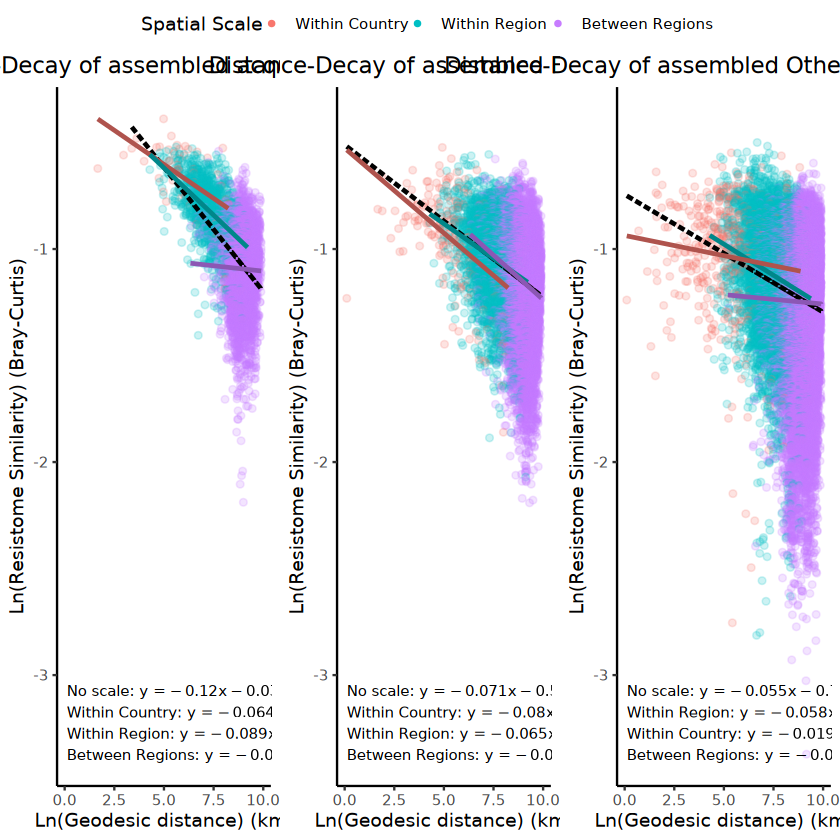

In [49]:
eq_size = 3 
ggarrange(
    add_plot_equations(p=variants.dists.rf.lms$p, eqns=variants.dists.rf.lms$equations, ymin=ymin, xmin=xmin, size = eq_size),
    add_plot_equations(p=variants.dists.fg.lms$p, eqns=variants.dists.fg.lms$equations, ymin=ymin, xmin=xmin, size = eq_size),
    add_plot_equations(p=variants.dists.other.lms$p, eqns=variants.dists.other.lms$equations, ymin=ymin, xmin=xmin, size = eq_size),
    ncol = 3, nrow=1, 
    common.legend=T
)

Warning message in grid.Call.graphics(C_lines, x$x, x$y, index, x$arrow):
“supplied color is neither numeric nor character”
Warning message in grid.Call.graphics(C_lines, x$x, x$y, index, x$arrow):
“supplied color is neither numeric nor character”
Warning message in grid.Call.graphics(C_lines, x$x, x$y, index, x$arrow):
“supplied color is neither numeric nor character”
Warning message in grid.Call.graphics(C_rect, x$x, x$y, x$width, x$height, resolveHJust(x$just, :
“supplied color is neither numeric nor character”
Warning message in grid.Call.graphics(C_rect, x$x, x$y, x$width, x$height, resolveHJust(x$just, :
“supplied color is neither numeric nor character”
Warning message in grid.Call.graphics(C_rect, x$x, x$y, x$width, x$height, resolveHJust(x$just, :
“supplied color is neither numeric nor character”
Warning message in grid.Call.graphics(C_lines, x$x, x$y, index, x$arrow):
“supplied color is neither numeric nor character”
Warning message in grid.Call.graphics(C_lines, x$x, x$y, ind

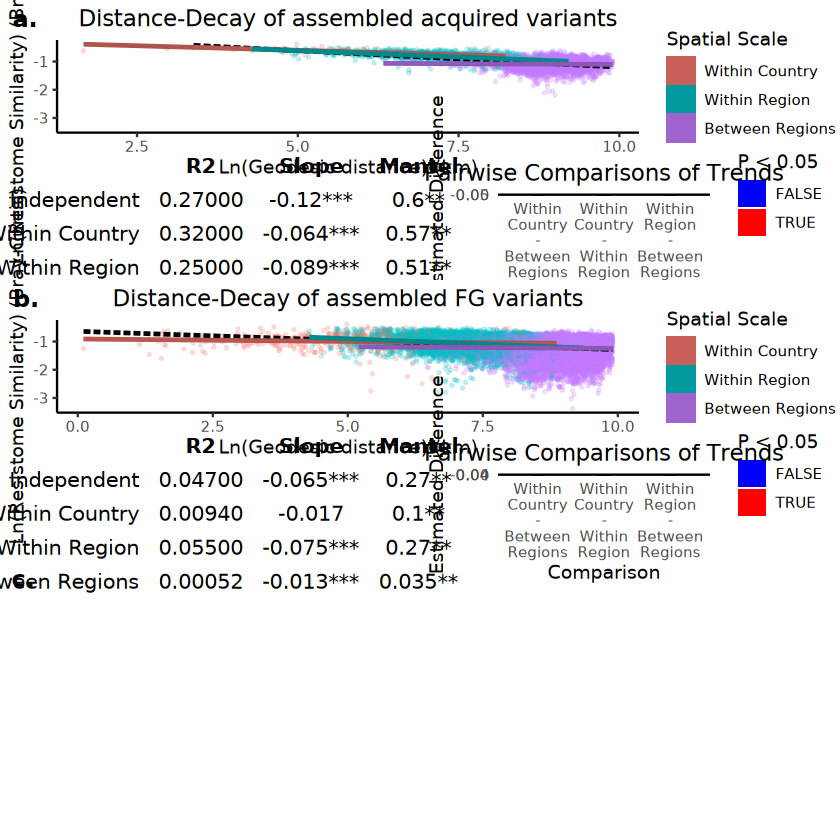

In [43]:
ggarrange(
    variants.dists.rf.lms$p2, 
    variants.dists.fg.lms$p2, 
    variants.dists.other.lms$p3, 
    ncol = 1,nrow=3,
    labels = c("a.", "b.", "c.")
)

ggsave(file.path(fig.dir, "dd_plots_assembled_variants_extended.png"), height = 18, width = 10, bg="white")
ggsave(file.path(fig.dir, "dd_plots_assembled_variants_extended.tiff"), height = 18, width = 10, bg="white")
ggsave(file.path(fig.dir, "dd_plots_assembled_variants_extended.pdf"), height = 18, width = 10, bg="white")

In [57]:
rbind(
    variants.dists.rf.lms$pairs %>% mutate(group = 'RF'),
    variants.dists.fg.lms$pairs %>% mutate(group = 'FG'),
    variants.dists.other.lms$pairs %>% mutate(group = 'Other')
) %>% mutate(
    star = case_when(
                    `p.value` <= 0.0001 ~ '***',
                    `p.value` <= 0.001 ~ '**',
                    `p.value` <= 0.01 ~ '*',
                    `p.value` <= 0.05 ~ '.',
                    TRUE ~ ' '
                )
    )

contrast,estimate,SE,df,t.ratio,p.value,group,star
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
Within Country - Within Region,0.024730711,0.017783945,4650,1.3906201,3.458744e-01,RF,
Within Country - Between Regions,-0.053753461,0.017503119,4650,-3.0710790,6.076167e-03,RF,*
Within Region - Between Regions,-0.078484173,0.008916512,4650,-8.8021161,3.897619e-08,RF,***
Within Country - Within Region,-0.014592215,0.010704821,16465,-1.3631443,3.604269e-01,FG,
Within Country - Between Regions,0.003904697,0.010337035,16465,0.3777386,9.243698e-01,FG,
Within Region - Between Regions,0.018496912,0.005973489,16465,3.0965006,5.567220e-03,FG,*
Within Country - Within Region,0.039450127,0.007847000,39896,5.0274151,1.487326e-06,Other,***
Within Country - Between Regions,-0.010061654,0.007428966,39896,-1.3543815,3.651308e-01,Other,
Within Region - Between Regions,-0.049511781,0.004892275,39896,-10.1203999,3.019807e-14,Other,***


### UMAP

In [50]:
n.variants.city <- rbind(
    as.data.frame(list("n_variants" = colSums(resClassObjs$all$variant$results$ResFinder.res$mat), group = "Acquired")) %>% rownames_to_column('city'),
    as.data.frame(list("n_variants" = colSums(resClassObjs$all$variant$results$Functional.res$mat), group = "FG")) %>% rownames_to_column('city'),
    as.data.frame(list("n_variants" = colSums(resClassObjs$all$variant$results$`Other ARGs.res`$mat), group = "Other ARGs")) %>% rownames_to_column('city')
)


umap.dfs <- rbind(
    create_umap(resClassObjs$all$variant$results$ResFinder.res$filtered) %>% mutate(group = 'Acquired'),
    create_umap(resClassObjs$all$variant$results$Functional.res$filtered) %>% mutate(group = 'FG'),
    create_umap(resClassObjs$all$variant$results$`Other ARGs.res`$filtered) %>% mutate(group = 'Other ARGs')
) %>%
    left_join(n.variants.city, by=c("city", "group")) %>%
    left_join(metadata %>% distinct(city, Region), by="city")

### Figure 3

Warning message:
“Removed 2 rows containing missing values or values outside the scale range (`geom_line()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range (`geom_line()`).”
Warning message:
“ggrepel: 95 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 182 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 283 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 60 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 165 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 273 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 52 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel

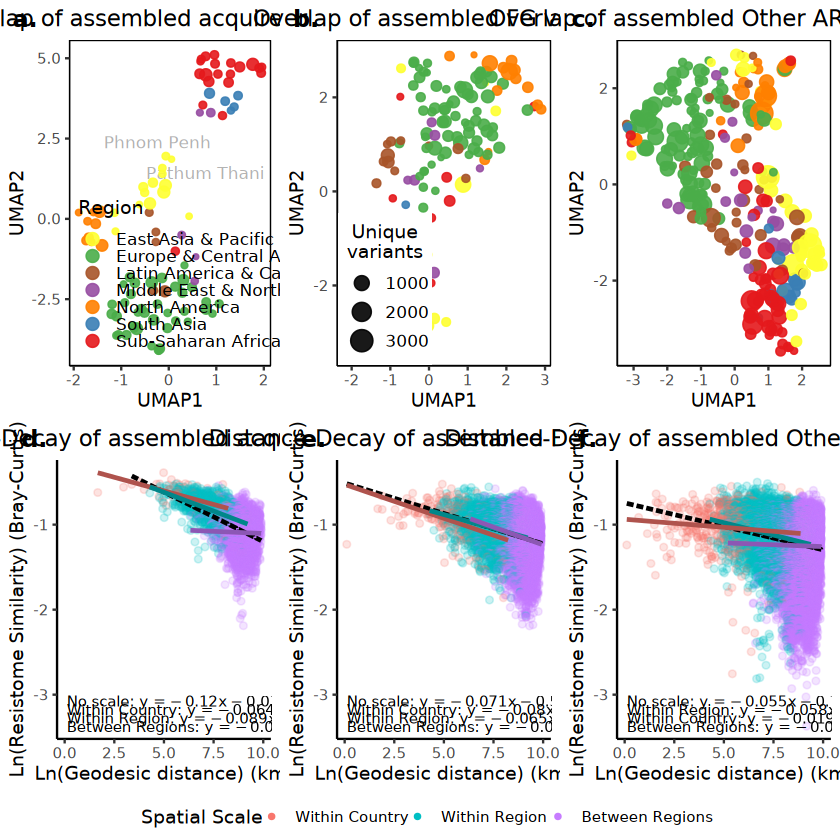

In [51]:
max.overlaps.rf = 8
max.overlaps.fg = 6
max.overlaps.other = 10
lw = .3
fontsize = 3.5
fontopacity = .3

p.umap.variant.rf <- umap.dfs %>%
    filter(group == 'Acquired') %>%
    ggplot(aes(X1, X2)) +
    geom_text_repel(aes(label=city), alpha = fontopacity, max.overlaps = max.overlaps.rf, size = fontsize) +
    geom_point(aes(size=n_variants, color=Region), alpha = .9) + 
    scale_color_manual(values=region_palette) +
    scale_size(limits = c(min(umap.dfs$n_variants), max(umap.dfs$n_variants))) + 
    labs(x='UMAP1', y='UMAP2', title = 'Overlap of assembled acquired variants') + 
    theme(
            legend.text=element_text(size=10),
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            panel.border = element_rect(color="black", fill = NA, linewidth = lw),
            panel.background = element_blank(),
            axis.line = element_line(colour = "black", linewidth = lw),
            #axis.ticks = element_blank(),
            #axis.text = element_blank(),
            plot.title = element_text(hjust = 0.5),
            legend.position = c("bottom", "left"),
            legend.justification = c(0.01, 0.01),
            legend.key.spacing.y = unit(-0.25, "cm"),
            legend.background = element_rect(color = NA, fill = NA)
        ) +
    guides(
        size = "none", #guide_legend(title="Region", title.position="top", title.hjust = 0.5),
        color = guide_legend(title="Region", byrow=T, override.aes = aes(size=3))
    )

p.umap.variant.fg <- umap.dfs %>%
    filter(group == 'FG') %>%
    ggplot(aes(X1, X2)) +
    geom_text_repel(aes(label=city), alpha = fontopacity, max.overlaps = max.overlaps.fg, size = fontsize) +
    geom_point(aes(size=n_variants, color=Region), alpha = .9) + 
    scale_color_manual(values=region_palette) +
    scale_size(limits = c(min(umap.dfs$n_variants), max(umap.dfs$n_variants))) + 
    labs(x='UMAP1', y='UMAP2', title = 'Overlap of assembled FG variants') + 
    theme(
            legend.text=element_text(size=10),
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            panel.border = element_rect(color="black", fill = NA, linewidth = lw),
            panel.background = element_blank(),
            axis.line = element_line(colour = "black", linewidth = lw),
            #axis.ticks = element_blank(),
            #axis.text = element_blank(),
            plot.title = element_text(hjust = 0.5),
            legend.position = c("bottom", "left"),
            legend.justification = c(0.01, 0.01)
        ) +
    guides(
        color = "none", #guide_legend(title="Region", title.position="top", title.hjust = 0.5, byrow=T, override.aes = aes(size=2)),
        size = guide_legend(title="Unique\nvariants", title.position="top", title.hjust = 0.5)
    )

p.umap.variant.other <- umap.dfs %>%
    filter(group == 'Other ARGs') %>%
    ggplot(aes(X1, X2)) +
    geom_text_repel(aes(label=city), alpha = fontopacity, max.overlaps = max.overlaps.other, size = fontsize) +
    geom_point(aes(size=n_variants, color=Region), alpha = .9) + 
    scale_color_manual(values=region_palette) +
    scale_size(limits = c(min(umap.dfs$n_variants), max(umap.dfs$n_variants))) + 
    labs(x='UMAP1', y='UMAP2', title = 'Overlap of assembled Other ARG variants') + 
    theme(
            legend.text=element_text(size=10),
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            panel.border = element_rect(color="black", fill = NA, linewidth = lw),
            panel.background = element_blank(),
            axis.line = element_line(colour = "black", linewidth = lw),
            #axis.ticks = element_blank(),
            #axis.text = element_blank(),
            plot.title = element_text(hjust = 0.5),
            legend.position = c("bottom", "left"),
            legend.justification = c(0.01, 0.01)
        )  +
    guides(
        color = "none", #guide_legend(title="Region", title.position="top", title.hjust = 0.5, byrow=T, override.aes = aes(size=2)),
        size = "none"
    )

p.umap.variant.all <- ggarrange(p.umap.variant.rf, p.umap.variant.fg, p.umap.variant.other, ncol=3,nrow=1, labels=c("a.", "b.", "c."))
p.dists.variant.all <-  ggarrange(
    add_plot_equations(p=variants.dists.rf.lms$p, eqns=variants.dists.rf.lms$equations, ymin=ymin, xmin=xmin, size = eq_size),
    add_plot_equations(p=variants.dists.fg.lms$p, eqns=variants.dists.fg.lms$equations, ymin=ymin, xmin=xmin, size = eq_size),
    add_plot_equations(p=variants.dists.other.lms$p, eqns=variants.dists.other.lms$equations, ymin=ymin, xmin=xmin, size = eq_size), 
    ncol=3, nrow=1, 
    common.legend = T, 
    labels=c("d.  ", "e.  ", "f.  "), 
    legend="bottom"
)

ggarrange(
    p.umap.variant.all,
    p.dists.variant.all,
    ncol = 1, nrow = 2
)

width = 15
height = 10

ggsave(
    file.path(fig.dir, "umap_dd_plots_variant_similarity_v2.png"), 
    width = width, height = height
)

ggsave(
    file.path(fig.dir, "umap_dd_plots_variant_similarity_v2.pdf"), 
    width = width, height = height
)

ggsave(
    file.path(fig.dir, "umap_dd_plots_variant_similarity_v2.tiff"), 
    width = width, height = height
)

### Slopes


In [55]:
var.lm.summaries <- rbind(
    variants.dists.rf.lms$fit.summaries %>% left_join(variants.dists.rf.lms$mantel.results, by = ("model"), suffix = c(".fit", ".mantel")) %>% mutate(Collection = 'Acquired'),
    variants.dists.fg.lms$fit.summaries %>% left_join(variants.dists.fg.lms$mantel.results, by = ("model"), suffix = c(".fit", ".mantel")) %>% mutate(Collection = 'FG'),
    variants.dists.other.lms$fit.summaries %>% left_join(variants.dists.other.lms$mantel.results, by = ("model"), suffix = c(".fit", ".mantel")) %>% mutate(Collection = 'Other')
)
var.lm.summaries

model,R2,Slope,P.value,signif.fit,Slope.str,mantel,r,p.value,signif.mantel,Collection
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>
Independent,0.27000,-0.1200,3.0138e-322,***,-0.12***,0.6**,0.600,0.001,**,Acquired
Within Country,0.32000,-0.0640,6.0000e-06,***,-0.064***,0.57**,0.570,0.001,**,Acquired
Within Region,0.25000,-0.0890,4.0000e-66,***,-0.089***,0.51**,0.510,0.001,**,Acquired
Between Regions,0.00044,-0.0100,1.1000e-01,,-0.01,0.013,0.013,0.230,,Acquired
Independent,0.08900,-0.0710,0.0000e+00,***,-0.071***,0.32**,0.320,0.001,**,FG
Within Country,0.26000,-0.0800,5.6000e-15,***,-0.08***,0.49**,0.490,0.001,**,FG
Within Region,0.07400,-0.0650,2.8000e-56,***,-0.065***,0.27**,0.270,0.001,**,FG
Between Regions,0.03500,-0.0840,1.7000e-102,***,-0.084***,0.19**,0.190,0.001,**,FG
Independent,0.03400,-0.0550,1.6000e-299,***,-0.055***,0.22**,0.220,0.001,**,Other


In [54]:
4.9000e-03<=0.001

[1] FALSE